# Seq2Class with Intention Model

In [91]:
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.models import load_model, Model, model_from_json
import keras.backend as K
from keras.callbacks import ModelCheckpoint

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

import random
import gensim
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Load FastText Model

In [92]:
model_w2v = gensim.models.fasttext.FastText.load('WE_models/fast_sg_300D')
word_dim = model_w2v.wv['.'].shape[0]
model_w2v.wv.most_similar('travail')

[('boulot', 0.6506392955780029),
 ('travailleur', 0.5885007381439209),
 ('travaillons', 0.543732762336731),
 ('travaillant', 0.5408203601837158),
 ('travailliez', 0.5360825657844543),
 ('travailler', 0.5263596773147583),
 ('travailleurs', 0.518135666847229),
 ('travaillerez', 0.5086672902107239),
 ('travaillé', 0.5048487186431885),
 ('travaille', 0.5045449733734131)]

## 2. Getting Data

In [97]:
data = read_sentences(path='./datasets_x/data.txt').astype(str)
target = read_sentences(path='./datasets_x/target.txt').astype(int)

m = data.shape[0]

data = [data[i].split() for i in range(m)]

target = read_sentences(path='./datasets_x/target.txt').astype(int)
target = target.reshape(len(target), 1)

print('The dataset contains {} samples'.format(m))

Tx = max([len(sentence) for sentence in data])
X = np.zeros((m, Tx, word_dim))

onehot_encoder = OneHotEncoder(sparse=False)
Y = onehot_encoder.fit_transform(target)
classes = Y.shape[1]
Y = Y.reshape((m, 1, classes))

for i in range(m):
    for j in range(len(data[i])):
        X[i, j, :] = model_w2v.wv[data[i][j]]
Ty = 10

# shuffle data
X, Y = shuffle(X, Y, random_state=0)

The dataset contains 100 samples


## Intention Model

### 1. Attention Mechanism 

The diagram on the right shows what one "Attention" step does to calculate the attention variables $\alpha^{\langle t, t' \rangle}$, which are used to compute the context variable $context^{\langle t \rangle}$ for each timestep in the output ($t=1, \ldots, T_y$). 

<table>
<td> 
<img src="images/attn_mechanism.png" style="width:500;height:500px;"> <br>
</td> 
</table>
<caption><center> **Figure 1**: Attention Component</center></caption>

To implement this model, two steps are required as described below : 

  * **one_step_attention**
  * **model**

In [98]:
# Shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")

# We are using a custom softmax(axis = 1) loaded in this notebook
activator = Activation(softmax, name='attention_weights') 
dotor = Dot(axes = 1)

In [99]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attetion) LSTM cell
    """

    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    concat = concatenator([s_prev, a])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies = densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a" to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    
    return context

In [100]:
n_a = 256
n_s = 256
post_activation_LSTM_cell = LSTM(n_s, return_state = True)

In [101]:
def model(Tx, Ty, n_a, n_s, word_dim=word_dim):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    word_dim -- size of a w2v word-vector

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of the model with a shape (Tx,)
    # Define s0 and c0, initial hidden state for the decoder LSTM of shape (n_s,)
    X = Input(shape=(Tx, word_dim))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []

    # Define the pre-attention Bi-LSTM, use return_sequences=True
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)
    
    # Iterate for Ty steps
    for t in range(Ty):
    
        # Perform one step of the attention mechanism to get back the context vector at step t
        context = one_step_attention(a, s)
        
        # Apply the post-attention LSTM cell to the "context" vector.
        # pass: initial_state = [hidden state, cell state] 
        s, _, c = post_activation_LSTM_cell(context, initial_state=[s, c])
        
        # Apply Dense layer to the hidden state output of the post-attention LSTM

    output = Dense(classes, activation='softmax')(s)
    
    # Create model instance taking three inputs and returning the output
    model = Model([X, s0, c0], output)
    
    return model

In [102]:
model = model(Tx, Ty, n_a, n_s)

In [103]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s0 (InputLayer)                 (None, 256)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 11, 300)      0                                            
__________________________________________________________________________________________________
repeat_vector_4 (RepeatVector)  (None, 11, 256)      0           s0[0][0]                         
                                                                 lstm_5[0][0]                     
                                                                 lstm_5[1][0]                     
                                                                 lstm_5[2][0]                     
          

In [104]:
# define the optimizer and compile model
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# define model enteries
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Y.swapaxes(0,1))

# define the checkpoint
filepath="models/weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=False, 
                             mode='min', 
                             save_weights_only=True)
callbacks_list = [checkpoint]

## Train Model

In [105]:
delete_weights()
epochs=100
history = model.fit([X, s0, c0], 
                    outputs, 
                    epochs=epochs, 
                    batch_size=24, 
                    #validation_split=0.2, 
                    verbose=2,
                    callbacks=callbacks_list,
                    shuffle=True)

Epoch 1/100
 - 5s - loss: 1.7995 - acc: 0.2700

Epoch 00001: saving model to models/weights-improvement-01-1.7995.hdf5
Epoch 2/100
 - 0s - loss: 1.2837 - acc: 0.3300

Epoch 00002: saving model to models/weights-improvement-02-1.2837.hdf5
Epoch 3/100
 - 0s - loss: 1.1131 - acc: 0.5200

Epoch 00003: saving model to models/weights-improvement-03-1.1131.hdf5
Epoch 4/100
 - 0s - loss: 0.7720 - acc: 0.7300

Epoch 00004: saving model to models/weights-improvement-04-0.7720.hdf5
Epoch 5/100
 - 0s - loss: 0.6970 - acc: 0.6900

Epoch 00005: saving model to models/weights-improvement-05-0.6970.hdf5
Epoch 6/100
 - 0s - loss: 0.6178 - acc: 0.7700

Epoch 00006: saving model to models/weights-improvement-06-0.6178.hdf5
Epoch 7/100
 - 0s - loss: 0.4559 - acc: 0.8400

Epoch 00007: saving model to models/weights-improvement-07-0.4559.hdf5
Epoch 8/100
 - 0s - loss: 0.4147 - acc: 0.8300

Epoch 00008: saving model to models/weights-improvement-08-0.4147.hdf5
Epoch 9/100
 - 0s - loss: 0.1489 - acc: 0.9500



 - 0s - loss: 4.2374e-04 - acc: 1.0000

Epoch 00069: saving model to models/weights-improvement-69-0.0004.hdf5
Epoch 70/100
 - 0s - loss: 4.1537e-04 - acc: 1.0000

Epoch 00070: saving model to models/weights-improvement-70-0.0004.hdf5
Epoch 71/100
 - 0s - loss: 4.0700e-04 - acc: 1.0000

Epoch 00071: saving model to models/weights-improvement-71-0.0004.hdf5
Epoch 72/100
 - 0s - loss: 3.9938e-04 - acc: 1.0000

Epoch 00072: saving model to models/weights-improvement-72-0.0004.hdf5
Epoch 73/100
 - 0s - loss: 3.9202e-04 - acc: 1.0000

Epoch 00073: saving model to models/weights-improvement-73-0.0004.hdf5
Epoch 74/100
 - 0s - loss: 3.8447e-04 - acc: 1.0000

Epoch 00074: saving model to models/weights-improvement-74-0.0004.hdf5
Epoch 75/100
 - 0s - loss: 3.7716e-04 - acc: 1.0000

Epoch 00075: saving model to models/weights-improvement-75-0.0004.hdf5
Epoch 76/100
 - 0s - loss: 3.7061e-04 - acc: 1.0000

Epoch 00076: saving model to models/weights-improvement-76-0.0004.hdf5
Epoch 77/100
 - 0s - 

In [111]:
history.history.keys()

dict_keys(['loss', 'acc'])

## Visualize The Model's History

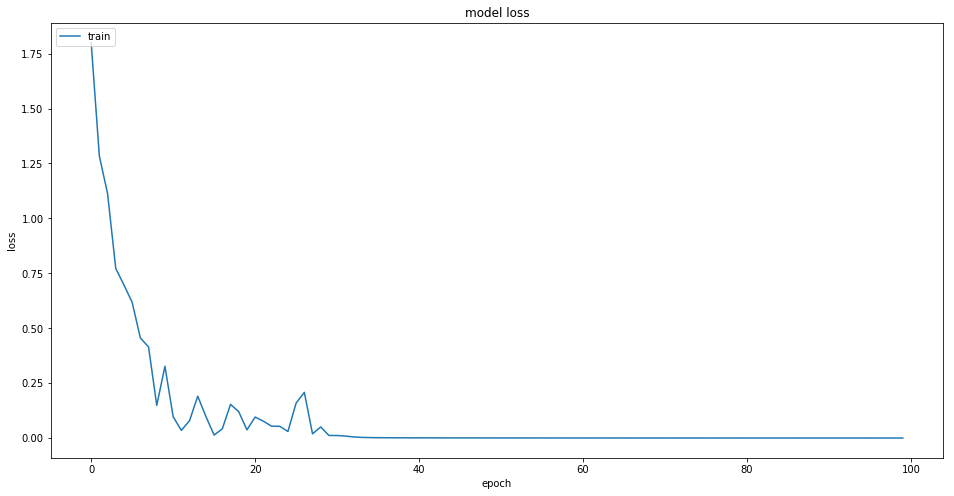

In [108]:
# summarize history for loss with the optimal element
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

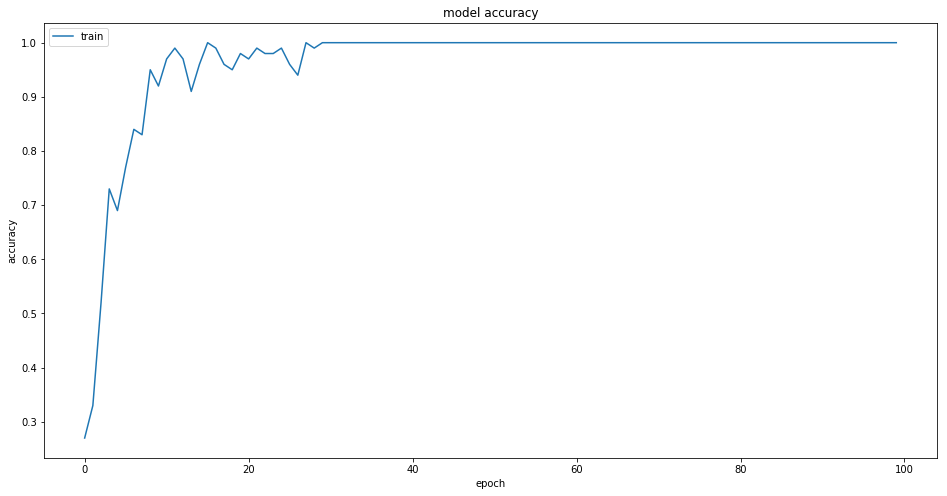

In [109]:
# summarize history for loss with the optimal element
plt.figure(figsize=(16, 8))
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Get the optimal model's weights

In [117]:
rounded_loss = round(history.history['loss'][epochs-1], 4)
filename = "models/weights-improvement-{}-{}.hdf5".format(epochs, rounded_loss)
model.load_weights(filename)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Sentence Decoding

In [126]:
def decode_sequence(input_seq):
    state_value = np.zeros((1, n_s))
    
    input_buffer = np.zeros((1, Tx, word_dim))
    input_words = input_seq.split()
    
    for i in range(len(input_words)):
        input_buffer[0, i, :] = model_w2v.wv[input_words[i]]
        
    return model.predict([input_buffer, state_value, state_value])

## Test on training sentences

In [127]:
classes_names = {1: "Youtube", 2:"LinkedIn", 3:"Google", 4:"Amazon", 5:"Booking"}

In [132]:
index = 99

sentence = ' '.join(data[index])
response = decode_sequence(sentence)

print('Moi : {}'.format(sentence))
print('Class : {}'.format(classes_names[np.argmax(response)+1]))
print('Expected: {} '.format(classes_names[target[index][0]]))

Moi : les meilleurs déstinations pour le prochain été
Class : Booking
Expected: Booking 


## Test on new sentences

In [157]:
sentence = "voyager au maroc"
response = decode_sequence(sentence)

print('Moi : {}'.format(sentence))
print('Class : {}'.format(classes_names[np.argmax(response)+1]))

Moi : voyager au maroc
Class : Booking


## Plot the model

In [147]:
# plot the model architecture
plot_model(model, to_file='seq2class_architecture.png', show_shapes=True)